In [20]:
from pandas import read_csv, DataFrame, concat
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam
from keras.constraints import nonneg
from matplotlib import pyplot
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import model_from_json
from os.path import isfile
import numpy as np 
import sys
import random
import os
from keras.losses import logcosh

In [21]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
def getXY(filename, scale):
    print(filename)
    dataset = read_csv(filename, header=0, index_col=0)
    dataset[["Searches"]] /= 100
    dataset[["Cases"]] = dataset[["Cases"]].apply(lambda x: x*100000/scale, axis=1)


    values = dataset.values.astype("float32")
    total_features = len(values[0])

    n_weeks = 4
    n_features = 2

    reframed = series_to_supervised(values, n_weeks, 1)
    values = reframed.values
    print("Reframed Shape: ", reframed.shape)
    totalFeatures = reframed.shape[1]
    n_obs = n_weeks * n_features

    x, y = values[:, :-2], values[:, -1] # Pick last week's cases as y and drop last week's 

    x = x.reshape((x.shape[0], n_weeks, n_features)) # Reshape as 3-D
    return x, y

In [23]:
def saveModel(model, modelName):
    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    model_json = model.to_json()
    with open(jsonName, "w") as json_file:
        json_file.write(model_json)
    #seralize weights to HDF5
    model.save_weights(h5Name)


In [24]:
def saveModel(model, modelName):
    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    model_json = model.to_json()
    with open(jsonName, "w") as json_file:
        json_file.write(model_json)
    #seralize weights to HDF5
    model.save_weights(h5Name)

In [25]:
def loadOrCreateModel(modelName): 

    jsonName = "{}.json".format(modelName)
    h5Name = "{}.h5".format(modelName)

    if(isfile(jsonName) and isfile(h5Name)):

        loaded_model_json = None
        with open(jsonName, "r") as json_file:
            loaded_model_json = json_file.read()

        model = model_from_json(loaded_model_json)
        model.load_weights(h5Name)
        model.compile(loss=[logcosh], optimizer="adam", metrics=["mse"])
        return model
    else:
        model = Sequential()
        model.add(LSTM(256, input_shape=(4, 2), return_sequences=True))
        model.add(LSTM(64, activation="relu", return_sequences=True))
        model.add(LSTM(32, activation="relu", return_sequences=False))

        model.add(Dense(128, activation="relu"))
        model.add(Dense(1, activation='linear', kernel_constraint=nonneg()))
        # model.add(Dense(1, activation="relu", kernel_constraint=nonneg()))
        model.compile(loss=[logcosh], optimizer="adam", metrics=["mse"])
        model.summary()
        return model

In [26]:
#Population values
population = {
    "casanare_2015-2017.csv" : 356438,
    "cordoba_2015-2017.csv" : 1709603,
    "cundinamarca_2015-2017.csv" : 2680041,
    "huila_2015-2017.csv" : 1154804,
    "meta_2015-2017.csv" : 961292,
    "santander_2015-2017.csv" : 2061095,
    "santander_norte_2015-2017.csv" : 1355723,
    "tolima_2015-2017.csv" : 1408274,
    "valle_cauca_2015-2017.csv" : 4613377,
}

In [27]:
def ExportPredictions(model, folder, test_files):
    for file in test_files:
        outputName = "Predictions-{}".format(file)
        x, y = getXY("{}/{}".format(dataFolder, file), population[file])
        with open("{}/{}".format(folder, outputName), "w") as outputFile:
            outputFile.write("Value,Prediction,Error\n")
            predictions = model.predict(x)
            y = y.reshape((len(y), 1))
            inv_yPred = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, predictions)
            inv_y = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, y)
            for i in range(len(inv_yPred)):
                yPred = float(inv_yPred[i])
                yReal = float(inv_y[i])
                outputFile.write("{},{},{}\n".format(yReal, yPred, yPred-yReal))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 4, 256)            265216    
_________________________________________________________________
lstm_8 (LSTM)                (None, 4, 64)             82176     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 364,161
Trainable params: 364,161
Non-trainable params: 0
_________________________________________________________________
../../../data/Colombia/processed_data/huila_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================]

Epoch 10/10
110/110 [==============================] - 0s 391us/step - loss: 4.7602 - mean_squared_error: 173.0492
../../../data/Colombia/processed_data/meta_2015-2017.csv
Reframed Shape:  (110, 10)
Test RMSE: 39.823
Total [ 4392.99997225]
len 110
../../../data/Colombia/processed_data/meta_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/tolima_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/valle_cauca_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/tolima_2015-2017.csv
Reframed Shape:  (110, 10)
Test RMSE: 119.586
Total [ 7027.99995188]
len 110
../../../data/Colombia/processed_data/meta_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/tolima_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/valle_cauca_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/valle_cauca_2015-2017.csv
Reframed Shape:  (110, 10)
Tes

Epoch 9/10
110/110 [==============================] - 0s 355us/step - loss: 5.0149 - mean_squared_error: 175.0675
Epoch 10/10
110/110 [==============================] - 0s 318us/step - loss: 4.9935 - mean_squared_error: 175.1768
../../../data/Colombia/processed_data/huila_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================] - 0s 300us/step - loss: 3.8977 - mean_squared_error: 120.3391
Epoch 2/10
110/110 [==============================] - 0s 418us/step - loss: 3.8475 - mean_squared_error: 120.3329
Epoch 3/10
110/110 [==============================] - 0s 327us/step - loss: 3.7674 - mean_squared_error: 120.8536
Epoch 4/10
110/110 [==============================] - 0s 291us/step - loss: 3.6668 - mean_squared_error: 122.1346
Epoch 5/10
110/110 [==============================] - 0s 373us/step - loss: 3.5729 - mean_squared_error: 124.2567
Epoch 6/10
110/110 [==============================] - 0s 355us/step - loss: 3.5007 - mean_squared_error: 127.1365
Ep

Epoch 8/10
110/110 [==============================] - 0s 336us/step - loss: 1.4048 - mean_squared_error: 14.5833
Epoch 9/10
110/110 [==============================] - 0s 318us/step - loss: 1.3370 - mean_squared_error: 12.8212
Epoch 10/10
110/110 [==============================] - 0s 309us/step - loss: 1.3029 - mean_squared_error: 11.9940
../../../data/Colombia/processed_data/santander_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================] - 0s 291us/step - loss: 1.4197 - mean_squared_error: 12.1817
Epoch 2/10
110/110 [==============================] - 0s 309us/step - loss: 1.3706 - mean_squared_error: 11.7513
Epoch 3/10
110/110 [==============================] - 0s 309us/step - loss: 1.3348 - mean_squared_error: 11.5245
Epoch 4/10
110/110 [==============================] - 0s 336us/step - loss: 1.3636 - mean_squared_error: 11.9083
Epoch 5/10
110/110 [==============================] - 0s 345us/step - loss: 1.3598 - mean_squared_error: 11.7571
Epoch 

Epoch 8/10
110/110 [==============================] - 0s 291us/step - loss: 0.7742 - mean_squared_error: 7.5933
Epoch 9/10
110/110 [==============================] - 0s 327us/step - loss: 0.7676 - mean_squared_error: 7.5210
Epoch 10/10
110/110 [==============================] - 0s 282us/step - loss: 0.7590 - mean_squared_error: 7.4211
../../../data/Colombia/processed_data/cordoba_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================] - 0s 282us/step - loss: 1.2662 - mean_squared_error: 23.5134
Epoch 2/10
110/110 [==============================] - 0s 291us/step - loss: 1.2568 - mean_squared_error: 23.3208
Epoch 3/10
110/110 [==============================] - 0s 300us/step - loss: 1.2434 - mean_squared_error: 23.1275
Epoch 4/10
110/110 [==============================] - 0s 309us/step - loss: 1.2276 - mean_squared_error: 22.9602
Epoch 5/10
110/110 [==============================] - 0s 309us/step - loss: 1.2108 - mean_squared_error: 22.8346
Epoch 6/10


Epoch 7/10
110/110 [==============================] - 0s 336us/step - loss: 2.6304 - mean_squared_error: 89.9000
Epoch 8/10
110/110 [==============================] - 0s 318us/step - loss: 2.7135 - mean_squared_error: 81.3001
Epoch 9/10
110/110 [==============================] - 0s 282us/step - loss: 2.9069 - mean_squared_error: 78.9678
Epoch 10/10
110/110 [==============================] - 0s 291us/step - loss: 2.8711 - mean_squared_error: 77.5450
../../../data/Colombia/processed_data/valle_cauca_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================] - 0s 291us/step - loss: 1.8928 - mean_squared_error: 19.6171
Epoch 2/10
110/110 [==============================] - 0s 318us/step - loss: 1.8833 - mean_squared_error: 19.8435
Epoch 3/10
110/110 [==============================] - 0s 318us/step - loss: 1.7968 - mean_squared_error: 18.4862
Epoch 4/10
110/110 [==============================] - 0s 364us/step - loss: 1.7226 - mean_squared_error: 16.8545
Epoc

Epoch 6/10
110/110 [==============================] - 0s 300us/step - loss: 4.0915 - mean_squared_error: 132.9622
Epoch 7/10
110/110 [==============================] - 0s 291us/step - loss: 4.0559 - mean_squared_error: 131.9295
Epoch 8/10
110/110 [==============================] - 0s 300us/step - loss: 4.0070 - mean_squared_error: 130.5019
Epoch 9/10
110/110 [==============================] - 0s 282us/step - loss: 3.9382 - mean_squared_error: 128.4837
Epoch 10/10
110/110 [==============================] - 0s 309us/step - loss: 3.8393 - mean_squared_error: 125.6001
../../../data/Colombia/processed_data/casanare_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================] - 0s 300us/step - loss: 9.0949 - mean_squared_error: 418.4423
Epoch 2/10
110/110 [==============================] - 0s 300us/step - loss: 8.8261 - mean_squared_error: 400.8036
Epoch 3/10
110/110 [==============================] - 0s 309us/step - loss: 8.4556 - mean_squared_error: 375.3344

Epoch 1/10
110/110 [==============================] - 5s 45ms/step - loss: 9.8365 - mean_squared_error: 467.3729
Epoch 2/10
110/110 [==============================] - 0s 373us/step - loss: 9.8015 - mean_squared_error: 464.7314
Epoch 3/10
110/110 [==============================] - 0s 309us/step - loss: 9.7924 - mean_squared_error: 464.2306
Epoch 4/10
110/110 [==============================] - 0s 327us/step - loss: 9.7771 - mean_squared_error: 463.3220
Epoch 5/10
110/110 [==============================] - 0s 355us/step - loss: 9.7546 - mean_squared_error: 461.8964
Epoch 6/10
110/110 [==============================] - 0s 318us/step - loss: 9.7230 - mean_squared_error: 459.8387
Epoch 7/10
110/110 [==============================] - 0s 382us/step - loss: 9.6793 - mean_squared_error: 456.9170
Epoch 8/10
110/110 [==============================] - 0s 345us/step - loss: 9.6185 - mean_squared_error: 452.8153
Epoch 9/10
110/110 [==============================] - 0s 318us/step - loss: 9.5330 - mean

../../../data/Colombia/processed_data/cordoba_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/santander_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/santander_norte_2015-2017.csv
Reframed Shape:  (110, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 4, 256)            265216    
_________________________________________________________________
lstm_29 (LSTM)               (None, 4, 64)             82176     
_________________________________________________________________
lstm_30 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Tot

Epoch 8/10
110/110 [==============================] - 0s 291us/step - loss: 1.4769 - mean_squared_error: 15.4070
Epoch 9/10
110/110 [==============================] - 0s 282us/step - loss: 1.3418 - mean_squared_error: 13.4502
Epoch 10/10
110/110 [==============================] - 0s 291us/step - loss: 1.2636 - mean_squared_error: 11.3624
../../../data/Colombia/processed_data/casanare_2015-2017.csv
Reframed Shape:  (110, 10)
Test RMSE: 29.351
Total [ 4008.9999981]
len 110
../../../data/Colombia/processed_data/casanare_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/santander_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/tolima_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_data/santander_2015-2017.csv
Reframed Shape:  (110, 10)
Test RMSE: 61.061
Total [ 10452.99999163]
len 110
../../../data/Colombia/processed_data/casanare_2015-2017.csv
Reframed Shape:  (110, 10)
../../../data/Colombia/processed_d

110/110 [==============================] - 0s 318us/step - loss: 1.5234 - mean_squared_error: 14.0417
Epoch 8/10
110/110 [==============================] - 0s 373us/step - loss: 1.4894 - mean_squared_error: 13.7548
Epoch 9/10
110/110 [==============================] - 0s 318us/step - loss: 1.4111 - mean_squared_error: 13.4701
Epoch 10/10
110/110 [==============================] - 0s 318us/step - loss: 1.3819 - mean_squared_error: 14.2681
../../../data/Colombia/processed_data/santander_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================] - 0s 291us/step - loss: 1.4438 - mean_squared_error: 12.8846
Epoch 2/10
110/110 [==============================] - 0s 291us/step - loss: 1.4451 - mean_squared_error: 12.9778
Epoch 3/10
110/110 [==============================] - 0s 409us/step - loss: 1.3811 - mean_squared_error: 12.0188
Epoch 4/10
110/110 [==============================] - 0s 309us/step - loss: 1.2797 - mean_squared_error: 10.6952
Epoch 5/10
110/11

Epoch 6/10
110/110 [==============================] - 0s 291us/step - loss: 1.3252 - mean_squared_error: 12.5247
Epoch 7/10
110/110 [==============================] - 0s 273us/step - loss: 1.3383 - mean_squared_error: 12.9143
Epoch 8/10
110/110 [==============================] - 0s 291us/step - loss: 1.3377 - mean_squared_error: 13.1023
Epoch 9/10
110/110 [==============================] - 0s 309us/step - loss: 1.3105 - mean_squared_error: 12.8306
Epoch 10/10
110/110 [==============================] - 0s 300us/step - loss: 1.2546 - mean_squared_error: 12.1845
../../../data/Colombia/processed_data/cordoba_2015-2017.csv
Reframed Shape:  (110, 10)
Epoch 1/10
110/110 [==============================] - 0s 291us/step - loss: 1.3337 - mean_squared_error: 25.0602
Epoch 2/10
110/110 [==============================] - 0s 346us/step - loss: 1.2809 - mean_squared_error: 23.9372
Epoch 3/10
110/110 [==============================] - 0s 300us/step - loss: 1.2246 - mean_squared_error: 23.1290
Epoch 4/

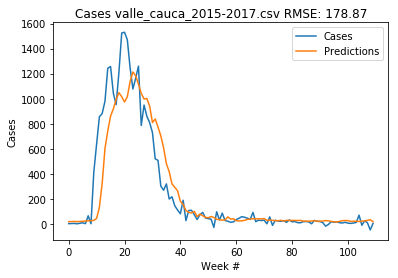

In [28]:
for i in range(10):
    os.mkdir("Experiments/{}".format(i))
    #Splits the files into 7-Train 3-Test
    dataFolder = "../../../data/Colombia/processed_data"
    files = os.listdir(dataFolder)
    train_files = random.sample(files, 6)
    test_files = list(filter(lambda x: x not in train_files, files))
    model = loadOrCreateModel("Model{}".format(i))
    
    for file in train_files:
        x,y = getXY("{}/{}".format(dataFolder, file), population[file])
        model.fit(x, y,
                 epochs = 10,
                 batch_size=x.shape[0],
                 verbose=1, 
                 shuffle=False)

    #Evaluate model
    for file in test_files:
        x, y = getXY("{}/{}".format(dataFolder, file), population[file])
        predictions = model.predict(x)
        y = y.reshape((len(y), 1))

        inv_yPred = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, predictions)
        inv_y = np.apply_along_axis(lambda x: x * population[file] / 100000, 1, y)

        rmse = sqrt(mean_squared_error(inv_y, inv_yPred))

        print('Test RMSE: %.3f' % rmse)
        print("Total", sum(inv_y))
        print("len", len(inv_y))
        pyplot.clf()
        pyplot.title("Cases {} RMSE: {:.2f}".format(file, rmse))
        pyplot.ylabel("Cases")
        pyplot.xlabel("Week #")
        pyplot.plot(inv_y, label="Cases")
        pyplot.plot(inv_yPred, label="Predictions")
        pyplot.legend()
        pngName = file.split(".")[0]
        pyplot.savefig('Experiments/{}/{}.png'.format(i, pngName))
        
        saveModel(model, "Experiments/{0}/model-{0}".format(i))
        ExportPredictions(model, "Experiments/{}".format(i), test_files)
    